<a href="https://colab.research.google.com/github/MahdieAghasi/HipLandmarkDetection/blob/main/BBVgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

1. Mount google drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. import libraries

In [ ]:
import glob
import os
import pandas as pd
import tqdm
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import cv2
from google.colab.patches import cv2_imshow

from statistics import mean, median, mode, stdev

from keras.callbacks import EarlyStopping

import time

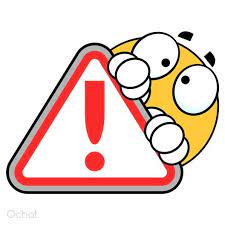
3. **Change tensorflow version**
In order to use the learning model step you need to change the tensorflow version to an older one.
Uncomment "!pip install tensorflow==2.8.0". Run it. Then Comment it. Restart the runtime and then you can run all the code.*italicized text*

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
#!pip install tensorflow==2.8.0

4. Indicate file paths

In [ ]:
file_path=[]
file_path='/content/drive/MyDrive/data/HighQuality/NewFilePaths.xlsx' #Path to landmarks

rpn_model_name = 'BBvgg16LAceL-1' #First stage model name
local_reg_model_name = 'BBvgg-reg-LAceL-1' #Second stage model name

TestFileDest = '/content/drive/MyDrive/Colab Notebooks/nov2022/2023/LAceL-1Test.xlsx' #Path to save model output for test set
paired_TestFileDest = '/content/drive/MyDrive/Colab Notebooks/nov2022/2023/LAceL-1PairedTest.xlsx' #Path to save model output for paired test set (images that are mirrored by test set)
AllFileDest = '/content/drive/MyDrive/Colab Notebooks/nov2022/2023/LAceL-1Total.xlsx' #Path to save model output for total dataset

5. Load the excel file, landmark positions, image names, image sizes

In [ ]:
data_all = []
folder_path = os.path.split(file_path)[0]
data = pd.read_excel(file_path, engine='openpyxl', sheet_name = 'ActualPoints')
data.rename({'Name': 'imgID', 'LAceL-x': 'x_ID', 'LAceL-y': 'y_ID'}, axis = 'columns', inplace=True) #you can change the landmark name here
data['image_folder_path'] = folder_path
data['imgID'] = data['imgID'].astype(str)
data_all.append(data[['imgID', 'x_ID', 'y_ID', 'image_folder_path', 'Height', 'Width']])

data_all = pd.concat(data_all)


print(data_all.shape)
data_all.head()

(853, 6)


,imgID,x_ID,y_ID,image_folder_path,Height,Width
0,MSC 000819088 [Dr Shirvani] {2021-11-10},707.5,1756.5,/content/drive/MyDrive/data/HighQuality,2805,3075
1,MSC 000819088 [Dr Shirvani] {2021-11-10}hflip,569.5,1792.5,/content/drive/MyDrive/data/HighQuality,2805,3075
2,MSC 990712056 [Dr Shirvani] {2020-10-03},683.5,1604.5,/content/drive/MyDrive/data/HighQuality,2658,3100
3,MSC 990712056 [Dr Shirvani] {2020-10-03}hflip,757.5,1530.5,/content/drive/MyDrive/data/HighQuality,2658,3100
4,MSC 990712083 [Dr Shirvani] {2020-10-03},695.5,1558.5,/content/drive/MyDrive/data/HighQuality,2752,3095


6. Load images. Make x (input image) and y (desired landmark positions)
You should uncomment this part for the first run

In [ ]:

all_img = []
IMG_SIZE = 224

"""
for counter in range(len(data_all)):
    # defining the image path
    img_folder_name = data_all['imgID'][counter]
    img_folder_path = data_all['image_folder_path'][counter]

    try:
        image_path = img_folder_path + '/' + img_folder_name + ".png"
        img = cv2.imread(image_path)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
        img_ = img_to_array(img)
        img_ = img_.astype('float32')
        all_img.append(img_)
    except:
        print(img_folder_path + '/' + img_folder_name + ".png" )
# converting the list to numpy array
x = np.array(all_img)

# defining the target
label_x_cord = data_all['x_ID'].values
label_x_cord = label_x_cord * IMG_SIZE / 3000
label_y_cord=data_all['y_ID'].values
label_y_cord = label_y_cord * IMG_SIZE / 3000
y=np.vstack((label_x_cord, label_y_cord)).T
"""

'\nfor counter in range(len(data_all)):\n    # defining the image path\n    img_folder_name = data_all[\'imgID\'][counter]\n    img_folder_path = data_all[\'image_folder_path\'][counter]\n\n    try:\n        image_path = img_folder_path + \'/\' + img_folder_name + ".png"\n        img = cv2.imread(image_path)\n        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)\n        img_ = img_to_array(img)\n        img_ = img_.astype(\'float32\')\n        all_img.append(img_)\n    except:\n        print(img_folder_path + \'/\' + img_folder_name + ".png" )\n# converting the list to numpy array\nx = np.array(all_img)\n\n# defining the target\nlabel_x_cord = data_all[\'x_ID\'].values\nlabel_x_cord = label_x_cord * IMG_SIZE / 3000\nlabel_y_cord=data_all[\'y_ID\'].values\nlabel_y_cord = label_y_cord * IMG_SIZE / 3000\ny=np.vstack((label_x_cord, label_y_cord)).T\n'

7. Save x and y for next times of running. Uncomment it for the first run.

In [ ]:
#np.save('/content/drive/MyDrive/Colab Notebooks/nov2022/x.npy',x)
#np.save('/content/drive/MyDrive/Colab Notebooks/nov2022/LAceL.npy',y)

NameError: ignored

8. Load your presaved x and y.

In [ ]:
x = np.load('/content/drive/MyDrive/Colab Notebooks/nov2022/x.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/nov2022/LAceL.npy')

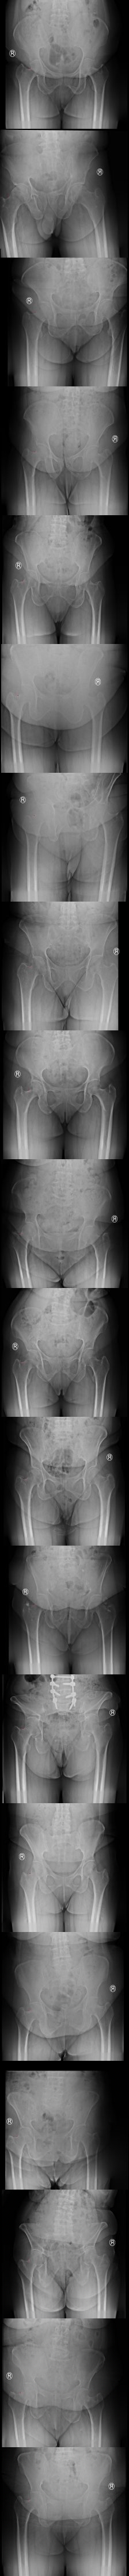

In [ ]:
plot_x = np.copy(x)
orig_x_20 = plot_x[-100::5]
y_plot = y[-100::5]
plot_img = []
for i in range(20):
  orig_x_20[i][int(y_plot[i][1]),int(y_plot[i][0])]=[0,0,255]
  plot_img.append(orig_x_20[i])
im_v = cv2.vconcat (plot_img)
cv2_imshow (im_v)

# First stage

1. Load test, train_validation, and paired test indexs

In [ ]:
test_index = np.load('/content/drive/MyDrive/Colab Notebooks/nov2022/test_index.npy')
train_validation_index = np.load('/content/drive/MyDrive/Colab Notebooks/nov2022/train_validation_index.npy')
paired_test_index = np.load('/content/drive/MyDrive/Colab Notebooks/nov2022/paired_test_index.npy')

2. Make test, train_validation, and paried test x and y for training procedure

In [ ]:
scaler = StandardScaler()
scaler.fit(y[train_validation_index])
y_normalized = scaler.transform(y)

train_validation_x = x[train_validation_index]
train_validation_y = y_normalized[train_validation_index]

test_x = x[test_index]
test_y = y_normalized[test_index]

paired_test_x = x[paired_test_index]
paired_test_y = y_normalized[paired_test_index]

(np.shape(train_validation_x), np.shape(train_validation_y)), (np.shape(test_x), np.shape(test_y)), (np.shape(paired_test_x), np.shape(paired_test_y))

(((726, 224, 224, 3), (726, 2)),
 ((127, 224, 224, 3), (127, 2)),
 ((127, 224, 224, 3), (127, 2)))

In [ ]:
fig, axs = plt.subplots(5,4, figsize=(100, 100))
axs = axs.ravel()
j=0
for i in range(740,760):
    x_anc, y_anc = y[i]
    b_size = 50
    color1 = (0, 255, 0)
    img = cv2.cvtColor(np.float32(x[i]), cv2.COLOR_RGB2GRAY)
    axs[j].imshow(img, cmap='gray')
    axs[j].plot(x_anc, y_anc, 'ro', markersize=20)
    j+=1

3. Defining model, batch size, number of epochs, and loss functions

In [ ]:
rpn_batch_size = 10
rpn_epochs = 300
def vgg_rpn_layer(VGG16_MODEL, input_size = (IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)

    # pre-trained embeddings from VGG16
    vgg16_output = VGG16_MODEL(inputs)

    # Model structure
    x = Conv2D(512*2, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(vgg16_output)
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv2')(x)
    x = Conv2D(9, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_conv3')(x)
    x = layers.Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(9)(x)
    x = Dense(2)(x)


    # Define and compile the model
    model = Model(inputs, x)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = custom_hard_loss, metrics = ['mae'])

    return model

def custom_soft_loss(y_actual, y_pred):
    """ The euclidean distance loss with a soft loss implementation
    """
    x1 = y_actual[:, 0]
    y1 = y_actual[:, 1]

    x2 = y_pred[:, 0]
    y2 = y_pred[:, 1]

    threshold = (6 / 512)**2
    distance = (x2 - x1)**2 + (y2 - y1)**2
    distance_alter = tf.zeros_like(distance)
    distance_final = tf.where(distance > threshold, distance, distance_alter)

    return tf.reduce_mean(distance_final)

def custom_hard_loss(y_actual, y_pred):
    """ The euclidean distance loss with a soft loss implementation
    """
    x1 = y_actual[:, 0]
    y1 = y_actual[:, 1]

    x2 = y_pred[:, 0]
    y2 = y_pred[:, 1]

    threshold = (0 / 512)**2
    distance = (x2 - x1)**2 + (y2 - y1)**2
    distance_alter = tf.zeros_like(distance)
    distance_final = tf.where(distance > threshold, distance, distance_alter)

    return tf.reduce_mean(distance_final)


4. Training. Uncomment the first time.

In [ ]:
os.makedirs("/content/drive/MyDrive/Colab Notebooks/nov2022/2023/results/", exist_ok = True)

rpn_checkpoint_path = f"/content/drive/MyDrive/Colab Notebooks/nov2022/2023/results/{rpn_model_name}.hdf5"
model_checkpoint = ModelCheckpoint(filepath=rpn_checkpoint_path, monitor='mae', verbose=1, save_best_only=True)

devices = tf.config.experimental.list_physical_devices('GPU')
mirrored_strategy = tf.distribute.MirroredStrategy(devices=['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3'])

st=time.time()

with mirrored_strategy.scope():
    IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')
    VGG16_MODEL.trainable=False

    # Let's take a look to see how many layers are in the VGG16 model
    print("Number of layers in the base model: ", len(VGG16_MODEL.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 18

    # Freeze all the layers before the 'fine_tune_at' layer
    for layer in VGG16_MODEL.layers[:fine_tune_at]:
        layer.trainable = False

    rpn_model = vgg_rpn_layer(VGG16_MODEL)
    rpn_model.summary()

    es = EarlyStopping(monitor='val_mae', verbose=1, min_delta=0.001, patience=10)
    cb_list=[model_checkpoint,es]
    cb_list=[model_checkpoint]

    print('Fitting model...')
"""
    history = rpn_model.fit(train_validation_x,
          train_validation_y,
          batch_size =rpn_batch_size,
          epochs=rpn_epochs,
          verbose=1,
          shuffle=True,
          validation_data=(test_x,test_y),
          callbacks=cb_list)
    print('-'*50)
    plt.plot(history.history['mae'][:], label='mae (training data)')
    plt.plot(history.history['val_mae'][:], label='mae (validation data)')
    plt.title('mae')
    plt.ylabel('mae value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.show()

print("training time: ", time.strftime("%H:%M:%S",time.gmtime(time.time()-st)))
"""

Number of layers in the base model:  19
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 rpn_conv1 (Conv2D)          (None, 7, 7, 1024)        4719616   
                                                                 
 rpn_conv2 (Conv2D)          (None, 7, 7, 512)         4719104   
                                                                 
 rpn_conv3 (Conv2D)          (None, 7, 7, 9)           4617      
                                                                 
 flatten_1 (Flatten)         (None, 441)               0         
                                                                 
 dropout_3 (Dropout

KeyboardInterrupt: ignored

5. Loading first stage model and make the outputs. Comment it for the first time.

In [ ]:
rpn_model_inference = tf.keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/nov2022/2023/results/{rpn_model_name}.hdf5', custom_objects={'custom_hard_loss': custom_hard_loss})

train_validation_rpn_predict_y = rpn_model_inference.predict(train_validation_x)
rpn_predict_y = rpn_model_inference.predict(x)

st=time.time()
test_rpn_predict_y = rpn_model_inference.predict(test_x)
print("test prediction time (model1): ", time.strftime("%H:%M:%S",time.gmtime(time.time()-st)))

paired_test_rpn_predict_y = rpn_model_inference.predict(paired_test_x)

rpn_predict_y_inversed = scaler.inverse_transform(rpn_predict_y)
rpn_y_inversed = scaler.inverse_transform(y_normalized)

train_validation_rpn_predict_y_inversed = scaler.inverse_transform(train_validation_rpn_predict_y)
train_validation_rpn_y_inversed = scaler.inverse_transform(train_validation_y)

test_rpn_predict_y_inversed = scaler.inverse_transform(test_rpn_predict_y)
test_rpn_y_inversed = scaler.inverse_transform(test_y)

paired_test_rpn_predict_y_inversed = scaler.inverse_transform(paired_test_rpn_predict_y)
paired_test_rpn_y_inversed = scaler.inverse_transform(paired_test_y)

TypeError: ignored

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(100, 100))
axs = axs.ravel()
j=0
for i in range(16):
    x_anc, y_anc = test_rpn_y_inversed[i]
    Px_anc, Py_anc = test_rpn_predict_y_inversed[i]
    b_size = 50
    color1 = (0, 255, 0)
    color2 = (100, 50, 50)
    img = cv2.cvtColor(np.float32(test_x[i]), cv2.COLOR_RGB2GRAY)
    cv2.rectangle(img, (int(x_anc-b_size/2), int(y_anc-b_size/2)), (int(x_anc+b_size/2), int(y_anc+b_size/2)), color1, 2)
    cv2.rectangle(img, (int(Px_anc-b_size/2), int(Py_anc-b_size/2)), (int(Px_anc+b_size/2), int(Py_anc+b_size/2)), color2, 2)
    axs[j].imshow(img, cmap='gray')
    axs[j].plot(Px_anc, Py_anc, 'ro', markersize=20)
    axs[j].plot(x_anc, y_anc, 'go', markersize=20)
    j+=1

In [ ]:
fig,ax=plt.subplots(1,1)
pred_dist_x = []
pred_dist_y = []
for i in range(len(test_rpn_y_inversed)):
  pred_dist_x.append(abs(test_rpn_y_inversed[i][0] - test_rpn_predict_y_inversed[i][0]))
  pred_dist_y.append(abs(test_rpn_y_inversed[i][1] - test_rpn_predict_y_inversed[i][1]))
cp = ax.scatter(pred_dist_x, pred_dist_y)
#ax.set(xlim=(0, 512), xticks=np.arange(1, 512, 64),
#       ylim=(0, 512), yticks=np.arange(1, 512, 64))

clb = fig.colorbar(cp)
#clb.ax.tick_params(labelsize=8)
clb.ax.set_title('Accuracy (pixels)',fontsize=8)
ax.set_title('Accuracy of Targets vs Image Position')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.show()

In [ ]:
fig,ax=plt.subplots(1,1)
pred_dist_x = []
pred_dist_y = []
for i in range(len(paired_test_rpn_y_inversed)):
  pred_dist_x.append(abs(paired_test_rpn_y_inversed[i][0] - paired_test_rpn_predict_y_inversed[i][0]))
  pred_dist_y.append(abs(paired_test_rpn_y_inversed[i][1] - paired_test_rpn_predict_y_inversed[i][1]))
cp = ax.scatter(pred_dist_x, pred_dist_y)
#ax.set(xlim=(0, 512), xticks=np.arange(1, 512, 64),
#       ylim=(0, 512), yticks=np.arange(1, 512, 64))

clb = fig.colorbar(cp)
#clb.ax.tick_params(labelsize=8)
clb.ax.set_title('Accuracy (pixels)',fontsize=8)
ax.set_title('Accuracy of Targets vs Image Position')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.show()

In [ ]:
fig,ax=plt.subplots(1,1)
pred_dist_x = []
pred_dist_y = []
for i in range(len(train_validation_rpn_y_inversed)):
  pred_dist_x.append(abs(train_validation_rpn_y_inversed[i][0] - train_validation_rpn_predict_y_inversed[i][0]))
  pred_dist_y.append(abs(train_validation_rpn_y_inversed[i][1] - train_validation_rpn_predict_y_inversed[i][1]))
cp = ax.scatter(pred_dist_x, pred_dist_y)
#ax.set(xlim=(0, 512), xticks=np.arange(1, 512, 64),
#       ylim=(0, 512), yticks=np.arange(1, 512, 64))

clb = fig.colorbar(cp)
#clb.ax.tick_params(labelsize=8)
clb.ax.set_title('Accuracy (pixels)',fontsize=8)
ax.set_title('Accuracy of Targets vs Image Position')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.show()

# Second stage

In [ ]:
def calculate_local_coords(x, y, Px, Py, box_size, IMG_SIZE):

    x_local = (x - Px + box_size/2) * IMG_SIZE / box_size
    y_local = (y - Py + box_size/2) * IMG_SIZE / box_size

    return [x_local, y_local]

1. Load cropped images for input around the predicted boxes

In [ ]:
# Load the images
img_dict = {}

y_cropped = []
box_size = 224

for i in range(len(y)):
    x_anc, y_anc = rpn_y_inversed[i]
    Px_anc, Py_anc = rpn_predict_y_inversed[i]
    y_cropped.append(calculate_local_coords(x_anc, y_anc, Px_anc, Py_anc, box_size, IMG_SIZE))

all_img_cropped = []

for counter in range(len(data_all)):

        img_folder_name = data_all['imgID'][counter]
        img_folder_path = data_all['image_folder_path'][counter]
        image_path = img_folder_path + '/' + img_folder_name + ".png"

        x_anc, y_anc = rpn_predict_y_inversed[counter]
        img = load_img(image_path, target_size = (int(IMG_SIZE*IMG_SIZE/box_size), int(IMG_SIZE*IMG_SIZE/box_size)))
        cropped_img = img.crop([(x_anc-box_size/2)*IMG_SIZE/box_size, (y_anc-box_size/2)*IMG_SIZE/box_size,
                          (x_anc+box_size/2)*IMG_SIZE/box_size, (y_anc+box_size/2)*IMG_SIZE/box_size])

        cropped_img = img_to_array(cropped_img)
        cropped_img = cropped_img.astype('float32')
        all_img_cropped.append(cropped_img)
        img.close()

# converting the list to numpy array
x_cropped = np.array(all_img_cropped)

y_cropped = y
x_cropped = x

2. Make test, train_validation, and paired test cropped x and y

In [ ]:
scaler = StandardScaler()
scaler.fit(np.array(y_cropped)[train_validation_index.astype(int)])
y_cropped_normalized = scaler.transform(y_cropped)

train_validation_cropped_x = x_cropped[train_validation_index]
train_validation_cropped_y = y_cropped_normalized[train_validation_index]

test_cropped_x = x_cropped[test_index]
test_cropped_y = y_cropped_normalized[test_index]

paired_test_cropped_x = x_cropped[test_index]
paired_test_cropped_y = y_cropped_normalized[test_index]

In [ ]:
fig, axs = plt.subplots(8,2, figsize=(100, 400))
axs = axs.ravel()
for i in range(16):

    axs[i].imshow(x_cropped[test_index[i]].astype(int), cmap='gray')
    axs[i].plot(y_cropped[test_index[i]][0], y_cropped[test_index[i]][1], 'ro', markersize=50)


In [ ]:
fig, axs = plt.subplots(8,2, figsize=(100, 400))
axs = axs.ravel()
for i in range(16):

    axs[i].imshow(x_cropped[paired_test_index[i]].astype(int), cmap='gray')
    axs[i].plot(y_cropped[paired_test_index[i]][0], y_cropped[paired_test_index[i]][1], 'ro', markersize=50)


3. Model definition

In [ ]:
reg_batch_size = 5
reg_epochs = 400
def vgg_reg_layer(VGG16_MODEL, input_size = (IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)

    vgg16_output = VGG16_MODEL(inputs)

    x = Conv2D(512 * 2, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(vgg16_output)
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv2')(x)

    x = Conv2D(9, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_conv3')(x)
    x = layers.Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(9)(x)
    x = Dense(2)(x)

    model = Model(inputs, x)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = custom_soft_loss, metrics = ['mae'])
    return model

5. Distance calculation functions

In [ ]:
def calculateDistance(x1,y1,x2,y2):
    """ calculate euclidean distance between points from CAD design and retrieved affined points from images"""
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def SinglecalculateDistance(x1,x2):
    """ calculate euclidean distance between points from CAD design and retrieved affined points from images"""
    dist = np.sqrt((x2 - x1)**2)
    return dist

6. Training the second stage model. Uncomment the first time

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/Colab Notebooks/nov2022/2023/results/{local_reg_model_name}.hdf5"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_mae', verbose=1, save_best_only=True)
devices = tf.config.experimental.list_physical_devices('GPU')
mirrored_strategy = tf.distribute.MirroredStrategy(devices=['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3'])

st=time.time()

with mirrored_strategy.scope():
    # Load VGG Model
    IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

    VGG16_MODEL.trainable=True

    # Let's take a look to see how many layers are in the VGG16 model
    print("Number of layers in the base model: ", len(VGG16_MODEL.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 18

    # Freeze all the layers before the 'fine_tune_at' layer
    for layer in VGG16_MODEL.layers[:fine_tune_at]:
        layer.trainable = False

    # Regression Model Training
    reg_model = vgg_reg_layer(VGG16_MODEL)
    reg_model.summary()
    print('Fitting model...')

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    print('Fitting model...')
"""
    history = reg_model.fit(train_validation_cropped_x,
          train_validation_cropped_y,
          batch_size =reg_batch_size,
          epochs=reg_epochs,
          verbose=1,
          shuffle=True,
          validation_data=(test_cropped_x, test_cropped_y),
          callbacks=[model_checkpoint])

    print('-'*50)
    plt.plot(history.history['loss'][:], label='Loss (training data)')
    plt.plot(history.history['val_loss'][:], label='Loss (validation data)')
    plt.title('Loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(history.history['mae'], label='MAE (training data)')
    plt.plot(history.history['val_mae'], label='MAE (validation data)')
    plt.title('MAE')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.show()

    #local_reg_model_inference = tf.keras.models.load_model(f'/content/drive/MyDrive/mahdie/results/{local_reg_model_name}.hdf5', custom_objects={'custom_soft_loss': custom_soft_loss})

    local_reg_model_inference= reg_model

    train_validation_cropped_y_pred = local_reg_model_inference.predict(train_validation_cropped_x)
    st1 = time.time()
    test_cropped_y_pred = local_reg_model_inference.predict(test_cropped_x)
    total_cropped_y_pred = local_reg_model_inference.predict(x_cropped)
    print("test prediction time (model2): ", time.strftime("%H:%M:%S",time.gmtime(time.time()-st1)))

    train_validation_cropped_y_inversed = scaler.inverse_transform(train_validation_cropped_y)
    test_cropped_y_inversed = scaler.inverse_transform(test_cropped_y)
    total_cropped_y_inversed = scaler.inverse_transform(y_cropped_normalized)

    train_validation_cropped_y_pred_inversed = scaler.inverse_transform(train_validation_cropped_y_pred)
    test_cropped_y_pred_inversed = scaler.inverse_transform(test_cropped_y_pred)
    total_cropped_y_pred_inversed = scaler.inverse_transform(total_cropped_y_pred)

    train_validation_cropped_y_pred_x_cord = train_validation_cropped_y_pred[:, 0]
    train_validation_cropped_y_pred_y_cord = train_validation_cropped_y_pred[:, 1]

    train_validation_cropped_y_x_cord = train_validation_cropped_y[:, 0]
    train_validation_cropped_y_y_cord = train_validation_cropped_y[:, 1]

    test_cropped_y_pred_x_cord = test_cropped_y_pred[:, 0]
    test_cropped_y_pred_y_cord = test_cropped_y_pred[:, 1]

    test_cropped_y_x_cord = test_cropped_y[:, 0]
    test_cropped_y_y_cord = test_cropped_y[:, 1]

    total_cropped_y_pred_x_cord = total_cropped_y_pred[:, 0]
    total_cropped_y_pred_y_cord = total_cropped_y_pred[:, 1]

    total_cropped_y_x_cord = y_cropped_normalized[:, 0]
    total_cropped_y_y_cord = y_cropped_normalized[:, 1]

    train_validation_cropped_y_pred_x_cord_inversed = train_validation_cropped_y_pred_inversed[:, 0]
    train_validation_cropped_y_pred_y_cord_inversed = train_validation_cropped_y_pred_inversed[:, 1]

    train_validation_cropped_y_x_cord_inversed = train_validation_cropped_y_inversed[:, 0]
    train_validation_cropped_y_y_cord_inversed = train_validation_cropped_y_inversed[:, 1]

    test_cropped_y_pred_x_cord_inversed = test_cropped_y_pred_inversed[:, 0]
    test_cropped_y_pred_y_cord_inversed = test_cropped_y_pred_inversed[:, 1]

    test_cropped_y_x_cord_inversed = test_cropped_y_inversed[:, 0]
    test_cropped_y_y_cord_inversed = test_cropped_y_inversed[:, 1]

    total_cropped_y_pred_x_cord_inversed = total_cropped_y_pred_inversed[:, 0]
    total_cropped_y_pred_y_cord_inversed = total_cropped_y_pred_inversed[:, 1]

    total_cropped_y_x_cord_inversed = total_cropped_y_inversed[:, 0]
    total_cropped_y_y_cord_inversed = total_cropped_y_inversed[:, 1]

    train_validation_distance_pixel   = calculateDistance(train_validation_cropped_y_x_cord_inversed, train_validation_cropped_y_y_cord_inversed, train_validation_cropped_y_pred_x_cord_inversed, train_validation_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
    train_x_distance_pixel = SinglecalculateDistance(train_validation_cropped_y_x_cord_inversed, train_validation_cropped_y_pred_x_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
    train_y_distance_pixel = SinglecalculateDistance(train_validation_cropped_y_y_cord_inversed, train_validation_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE

    test_distance_pixel    = calculateDistance(test_cropped_y_x_cord_inversed,  test_cropped_y_y_cord_inversed,  test_cropped_y_pred_x_cord_inversed,  test_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
    test_x_distance_pixel  = SinglecalculateDistance(test_cropped_y_x_cord_inversed, test_cropped_y_pred_x_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
    test_y_distance_pixel  = SinglecalculateDistance(test_cropped_y_y_cord_inversed, test_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE

    total_distance_pixel    = calculateDistance(total_cropped_y_x_cord_inversed, total_cropped_y_y_cord_inversed, total_cropped_y_pred_x_cord_inversed,  total_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
    total_x_distance_pixel  = SinglecalculateDistance(total_cropped_y_x_cord_inversed, total_cropped_y_pred_x_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
    total_y_distance_pixel  = SinglecalculateDistance(total_cropped_y_y_cord_inversed, total_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE

    print('The average eucliean distance error of prediction result for train is  ',mean(train_validation_distance_pixel),'with standard deviation ',stdev(train_validation_distance_pixel))
    print('The average eucliean distance error of prediction result for test is  ',mean(test_distance_pixel),'with standard deviation ',stdev(test_distance_pixel))

print("training one fold time: ", time.strftime("%H:%M:%S",time.gmtime(time.time()-st)))
"""

7. Load and test second stage model.

In [ ]:
local_reg_model_inference = tf.keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/nov2022/2023/results/{local_reg_model_name}.hdf5', custom_objects={'custom_soft_loss': custom_soft_loss})

local_reg_model_inference= reg_model

train_validation_cropped_y_pred = local_reg_model_inference.predict(train_validation_cropped_x)
st1 = time.time()
test_cropped_y_pred = local_reg_model_inference.predict(test_cropped_x)
paired_test_cropped_y_pred = local_reg_model_inference.predict(paired_test_cropped_x)
total_cropped_y_pred = local_reg_model_inference.predict(x_cropped)
print("test prediction time (model2): ", time.strftime("%H:%M:%S",time.gmtime(time.time()-st1)))

train_validation_cropped_y_inversed = scaler.inverse_transform(train_validation_cropped_y)
test_cropped_y_inversed = scaler.inverse_transform(test_cropped_y)
paired_test_cropped_y_inversed = scaler.inverse_transform(paired_test_cropped_y)
total_cropped_y_inversed = scaler.inverse_transform(y_cropped_normalized)

train_validation_cropped_y_pred_inversed = scaler.inverse_transform(train_validation_cropped_y_pred)
test_cropped_y_pred_inversed = scaler.inverse_transform(test_cropped_y_pred)
paired_test_cropped_y_pred_inversed = scaler.inverse_transform(paired_test_cropped_y_pred)
total_cropped_y_pred_inversed = scaler.inverse_transform(total_cropped_y_pred)

train_validation_cropped_y_pred_x_cord = train_validation_cropped_y_pred[:, 0]
train_validation_cropped_y_pred_y_cord = train_validation_cropped_y_pred[:, 1]

train_validation_cropped_y_x_cord = train_validation_cropped_y[:, 0]
train_validation_cropped_y_y_cord = train_validation_cropped_y[:, 1]

test_cropped_y_pred_x_cord = test_cropped_y_pred[:, 0]
test_cropped_y_pred_y_cord = test_cropped_y_pred[:, 1]

test_cropped_y_x_cord = test_cropped_y[:, 0]
test_cropped_y_y_cord = test_cropped_y[:, 1]

paired_test_cropped_y_pred_x_cord = paired_test_cropped_y_pred[:, 0]
paired_test_cropped_y_pred_y_cord = paired_test_cropped_y_pred[:, 1]

paired_test_cropped_y_x_cord = paired_test_cropped_y[:, 0]
paired_test_cropped_y_y_cord = paired_test_cropped_y[:, 1]

total_cropped_y_pred_x_cord = total_cropped_y_pred[:, 0]
total_cropped_y_pred_y_cord = total_cropped_y_pred[:, 1]

total_cropped_y_x_cord = y_cropped_normalized[:, 0]
total_cropped_y_y_cord = y_cropped_normalized[:, 1]

train_validation_cropped_y_pred_x_cord_inversed = train_validation_cropped_y_pred_inversed[:, 0]
train_validation_cropped_y_pred_y_cord_inversed = train_validation_cropped_y_pred_inversed[:, 1]

train_validation_cropped_y_x_cord_inversed = train_validation_cropped_y_inversed[:, 0]
train_validation_cropped_y_y_cord_inversed = train_validation_cropped_y_inversed[:, 1]

test_cropped_y_pred_x_cord_inversed = test_cropped_y_pred_inversed[:, 0]
test_cropped_y_pred_y_cord_inversed = test_cropped_y_pred_inversed[:, 1]

test_cropped_y_x_cord_inversed = test_cropped_y_inversed[:, 0]
test_cropped_y_y_cord_inversed = test_cropped_y_inversed[:, 1]

paired_test_cropped_y_pred_x_cord_inversed = paired_test_cropped_y_pred_inversed[:, 0]
paired_test_cropped_y_pred_y_cord_inversed = paired_test_cropped_y_pred_inversed[:, 1]

paired_test_cropped_y_x_cord_inversed = paired_test_cropped_y_inversed[:, 0]
paired_test_cropped_y_y_cord_inversed = paired_test_cropped_y_inversed[:, 1]

total_cropped_y_pred_x_cord_inversed = total_cropped_y_pred_inversed[:, 0]
total_cropped_y_pred_y_cord_inversed = total_cropped_y_pred_inversed[:, 1]

total_cropped_y_x_cord_inversed = total_cropped_y_inversed[:, 0]
total_cropped_y_y_cord_inversed = total_cropped_y_inversed[:, 1]

train_validation_distance_pixel   = calculateDistance(train_validation_cropped_y_x_cord_inversed, train_validation_cropped_y_y_cord_inversed, train_validation_cropped_y_pred_x_cord_inversed, train_validation_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
train_x_distance_pixel = SinglecalculateDistance(train_validation_cropped_y_x_cord_inversed, train_validation_cropped_y_pred_x_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
train_y_distance_pixel = SinglecalculateDistance(train_validation_cropped_y_y_cord_inversed, train_validation_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE

test_distance_pixel    = calculateDistance(test_cropped_y_x_cord_inversed,  test_cropped_y_y_cord_inversed,  test_cropped_y_pred_x_cord_inversed,  test_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
test_x_distance_pixel  = SinglecalculateDistance(test_cropped_y_x_cord_inversed, test_cropped_y_pred_x_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
test_y_distance_pixel  = SinglecalculateDistance(test_cropped_y_y_cord_inversed, test_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE

paired_test_distance_pixel    = calculateDistance(paired_test_cropped_y_x_cord_inversed, paired_test_cropped_y_y_cord_inversed, paired_test_cropped_y_pred_x_cord_inversed, paired_test_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
paired_test_x_distance_pixel  = SinglecalculateDistance(paired_test_cropped_y_x_cord_inversed, paired_test_cropped_y_pred_x_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
paired_test_y_distance_pixel  = SinglecalculateDistance(paired_test_cropped_y_y_cord_inversed, paired_test_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE

total_distance_pixel    = calculateDistance(total_cropped_y_x_cord_inversed, total_cropped_y_y_cord_inversed, total_cropped_y_pred_x_cord_inversed,  total_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
total_x_distance_pixel  = SinglecalculateDistance(total_cropped_y_x_cord_inversed, total_cropped_y_pred_x_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE
total_y_distance_pixel  = SinglecalculateDistance(total_cropped_y_y_cord_inversed, total_cropped_y_pred_y_cord_inversed) * box_size * 512 / IMG_SIZE / IMG_SIZE

print('The average eucliean distance error of prediction result for train is  ',mean(train_validation_distance_pixel),'with standard deviation ',stdev(train_validation_distance_pixel))
print('The average eucliean distance error of prediction result for test is  ',mean(test_distance_pixel),'with standard deviation ',stdev(test_distance_pixel))
print('The average eucliean distance error of prediction result for paired_test is  ',mean(paired_test_distance_pixel),'with standard deviation ',stdev(paired_test_distance_pixel))


In [ ]:
TooBadTrain=[]
for i in range(len(train_validation_distance_pixel)):
  if train_validation_distance_pixel[i]>(2*mean(train_validation_distance_pixel)):
    TooBadTrain.append(i)

fig, axes = plt.subplots(int(len(TooBadTrain)/4+0.75), 4, figsize=(100,25*int(len(TooBadTrain)/4+0.75)))
axes = axes.ravel()

j=0
for i in TooBadTrain:
    img = train_validation_x[i].astype(int)
    color = (0, 255, 0)

    x1_anc = rpn_predict_y_inversed[train_validation_index[i]][0] - box_size/2
    y1_anc = rpn_predict_y_inversed[train_validation_index[i]][1] - box_size/2
    x_cropped_cord_pred = train_validation_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = train_validation_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred#/IMG_SIZE*box_size + x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred#/IMG_SIZE*box_size + y1_anc

    x_cropped_cord = train_validation_cropped_y_inversed[i][0]
    y_cropped_cord = train_validation_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord#/IMG_SIZE*box_size + x1_anc
    y_cropped_cord_global = y_cropped_cord#/IMG_SIZE*box_size + y1_anc

    axes[j].imshow(img)#, cmap='gray')
    axes[j].plot(x_cropped_cord_global, y_cropped_cord_global, 'ro', markersize=20)
    axes[j].plot(x_cropped_cord_pred_global, y_cropped_cord_pred_global, 'bo', markersize=20)
    j+=1

plt.show()

In [ ]:
TooBadTest=[]
for i in range(len(test_distance_pixel)):
  if test_distance_pixel[i]>(2*mean(test_distance_pixel)):
    TooBadTest.append(i)

fig, axes = plt.subplots(int(len(TooBadTest)/4+0.75), 4, figsize=(100,25*int(len(TooBadTest)/4+0.75)))
axes = axes.ravel()

j=0
for i in TooBadTest:
    #x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[i]]
    #img = cv2.cvtColor(np.float32(test_x[i]), cv2.COLOR_RGB2GRAY)
    #cv2.rectangle(img, (int(x1_anc), int(y1_anc)), (int(x2_anc), int(y2_anc)), color, 2)
    #axs[j].imshow(img, cmap='gray')
    #axs[j].plot(y[test_index[i]][0], y[test_index[i]][1], 'ro', markersize=50)


    img = test_x[i].astype(int)
    color = (0, 255, 0)
    x1_anc = rpn_predict_y_inversed[test_index[i]][0] - box_size/2
    y1_anc = rpn_predict_y_inversed[test_index[i]][1] - box_size/2
    x_cropped_cord_pred = test_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = test_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred#/IMG_SIZE*box_size + x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred#/IMG_SIZE*box_size + y1_anc

    x_cropped_cord = test_cropped_y_inversed[i][0]
    y_cropped_cord = test_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord#/IMG_SIZE*box_size + x1_anc
    y_cropped_cord_global = y_cropped_cord#/IMG_SIZE*box_size + y1_anc

    axes[j].imshow(img)#, cmap='gray')
    #axes[j].plot(y[test_index[i]][0], y[test_index[i]][1], 'ro', markersize=50)#

    axes[j].plot(x_cropped_cord_global, y_cropped_cord_global, 'ro', markersize=20)
    axes[j].plot(x_cropped_cord_pred_global, y_cropped_cord_pred_global, 'bo', markersize=20)
    j+=1
plt.show()



In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(100,125))
axes = axes.ravel()

for i in range(20,40):
    #x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[i]]
    #img = cv2.cvtColor(np.float32(test_x[i]), cv2.COLOR_RGB2GRAY)
    #cv2.rectangle(img, (int(x1_anc), int(y1_anc)), (int(x2_anc), int(y2_anc)), color, 2)
    #axs[j].imshow(img, cmap='gray')
    #axs[j].plot(y[test_index[i]][0], y[test_index[i]][1], 'ro', markersize=50)


    img = test_x[i].astype(int)
    color = (0, 255, 0)
    x1_anc = rpn_predict_y_inversed[test_index[i]][0] - box_size/2
    y1_anc = rpn_predict_y_inversed[test_index[i]][1] - box_size/2
    x_cropped_cord_pred = test_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = test_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred#/IMG_SIZE*box_size + x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred#/IMG_SIZE*box_size + y1_anc

    x_cropped_cord = test_cropped_y_inversed[i][0]
    y_cropped_cord = test_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord#/IMG_SIZE*box_size + x1_anc
    y_cropped_cord_global = y_cropped_cord#/IMG_SIZE*box_size + y1_anc

    axes[i-20].imshow(img)#, cmap='gray')

    axes[i-20].plot(x_cropped_cord_global, y_cropped_cord_global, 'ro', markersize=20)
    axes[i-20].plot(x_cropped_cord_pred_global, y_cropped_cord_pred_global, 'bo', markersize=20)

plt.show()

In [ ]:
fig, axes = plt.subplots(10, 2, figsize=(100,500))
axes = axes.ravel()

for i in range(20):
    img = test_cropped_x[i].astype(int)
    x_cropped_cord_pred = test_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = test_cropped_y_pred_inversed[i][1]
    x_cropped_cord = test_cropped_y_inversed[i][0]
    y_cropped_cord = test_cropped_y_inversed[i][1]

    axes[i].imshow(img, cmap='gray')
    axes[i].plot(x_cropped_cord, y_cropped_cord, 'ro', markersize=50)
    axes[i].plot(x_cropped_cord_pred, y_cropped_cord_pred, 'bo', markersize=50)
plt.show()

In [ ]:
fig, axes = plt.subplots(10, 2, figsize=(100,500))
axes = axes.ravel()

for i in range(20):
    img = train_validation_cropped_x[i].astype(int)
    x_cropped_cord_pred = train_validation_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = train_validation_cropped_y_pred_inversed[i][1]
    x_cropped_cord = train_validation_cropped_y_inversed[i][0]
    y_cropped_cord = train_validation_cropped_y_inversed[i][1]

    axes[i].imshow(img, cmap='gray')
    axes[i].plot(x_cropped_cord, y_cropped_cord, 'ro', markersize=50)
    axes[i].plot(x_cropped_cord_pred, y_cropped_cord_pred, 'bo', markersize=50)
plt.show()

In [ ]:
def calculate_global_dist (x1, x2, IMG_SIZE, box_size):

  x11 = x1[0]
  x12 = x1[1]
  x21 = x2[0]
  x22 = x2[1]

  dist = np.sqrt((x11-x21)**2+(x12-x22)**2) * box_size/IMG_SIZE
  return dist

TestDist=[]
for i,j in enumerate(test_index):
  dist=calculate_global_dist(test_cropped_y_pred_inversed[i] , test_cropped_y_inversed[i], IMG_SIZE, box_size)
  TestDist.append(dist)

paired_TestDist=[]
for i,j in enumerate(paired_test_index):
  dist=calculate_global_dist(paired_test_cropped_y_pred_inversed[i] , paired_test_cropped_y_inversed[i], IMG_SIZE, box_size)
  paired_TestDist.append(dist)

TotalDist=[]
for i in range(len(y_normalized)):
  dist=calculate_global_dist(total_cropped_y_pred_inversed[i] , total_cropped_y_inversed[i], IMG_SIZE, box_size)
  TotalDist.append(dist)


In [ ]:
print(stdev(TestDist)*512/224)
print(mean(TestDist)*512/224)

In [ ]:
# Plot the distance between prediction and labels for right_test_distance_pixel

# right_test_distance = np.load('/content/drive/MyDrive/Colab Notebooks/SaraH/distanceResults/rpn5*5fold/right_test.npy')
right_test_distance = TestDist

max_dist = max(right_test_distance)
# print(max_dist)
cnt = np.zeros(round(max_dist))
for i in range(len(right_test_distance)):
  for j in range(round(max_dist)):
    if j <= right_test_distance[i] < j+1:
      cnt[j] += 1
# print(cnt)

fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
a = np.arange(0,round(max_dist))
b = cnt
# print(max_dist)
# print(len(a))
# print(len(b))

ax.set_xticks(np.arange(0, len(a)+1, 10))
ax.set_yticks(np.arange(0, max(b), 1))
plt.xlabel('Prediction-label Pixel-wise distance')
plt.ylabel('# of samples')
ax.grid()
ax.bar(a,b)
plt.show()


In [ ]:
# Plot the distance between prediction and labels for right_test_distance_pixel

# right_test_distance = np.load('/content/drive/MyDrive/Colab Notebooks/SaraH/distanceResults/rpn5*5fold/right_test.npy')
right_test_distance = TotalDist

max_dist = max(right_test_distance)
# print(max_dist)
cnt = np.zeros(round(max_dist))
for i in range(len(right_test_distance)):
  for j in range(round(max_dist)):
    if j <= right_test_distance[i] < j+1:
      cnt[j] += 1
# print(cnt)

fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
a = np.arange(0,round(max_dist))
b = cnt
# print(max_dist)
# print(len(a))
# print(len(b))

ax.set_xticks(np.arange(0, len(a)+1, 10))
ax.set_yticks(np.arange(0, max(b), 1))
plt.xlabel('Prediction-label Pixel-wise distance')
plt.ylabel('# of samples')
ax.grid()
ax.bar(a,b)
plt.show()


In [ ]:
test_y_global=[]
test_x_global=[]
test_y_pred_global=[]
test_x_pred_global=[]

for i in range(len(test_y)):

    x1_anc = rpn_predict_y_inversed[test_index[i]][0] - box_size/2
    y1_anc = rpn_predict_y_inversed[test_index[i]][1] - box_size/2

    x_cropped_cord_pred = test_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = test_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred/IMG_SIZE*box_size# + x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred/IMG_SIZE*box_size# + y1_anc

    test_x_pred_global.append(x_cropped_cord_pred_global*512/IMG_SIZE)
    test_y_pred_global.append(y_cropped_cord_pred_global*512/IMG_SIZE)

    x_cropped_cord = test_cropped_y_inversed[i][0]
    y_cropped_cord = test_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord/IMG_SIZE*box_size #+ x1_anc
    y_cropped_cord_global = y_cropped_cord/IMG_SIZE*box_size #+ y1_anc

    test_x_global.append(x_cropped_cord_global*512/IMG_SIZE)
    test_y_global.append(y_cropped_cord_global*512/IMG_SIZE)

fig,ax=plt.subplots(1,1)
cp = ax.scatter(test_x_global[:], test_y_global[:], c=TestDist)
ax.set(xlim=(0, 512), xticks=np.arange(1, 512, 64),
       ylim=(0, 512), yticks=np.arange(1, 512, 64))

clb = fig.colorbar(cp)
#clb.ax.tick_params(labelsize=8)
clb.ax.set_title('Accuracy (pixels)',fontsize=8)
ax.set_title('Accuracy of Targets vs Image Position')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.show()

In [ ]:
output = pd.DataFrame({'x' : [], 'y' : [], 'Px' : [], 'Py': [], 'Height': [], 'Width': []})

output ['Height'] = data_all ['Height'] [test_index]
output ['Width'] = data_all ['Width'] [test_index]

output['Px'] = test_x_pred_global
output['Py'] = test_y_pred_global

output['x'] = test_x_global
output['y'] = test_y_global

output.head()
output.to_excel(TestFileDest, index = False)


In [ ]:
paired_test_y_global=[]
paired_test_x_global=[]
paired_test_y_pred_global=[]
paired_test_x_pred_global=[]

for i in range(len(paired_test_y)):

    x1_anc = rpn_predict_y_inversed[paired_test_index[i]][0] - box_size/2
    y1_anc = rpn_predict_y_inversed[paired_test_index[i]][1] - box_size/2

    x_cropped_cord_pred = paired_test_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = paired_test_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred/IMG_SIZE*box_size #+ x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred/IMG_SIZE*box_size #+ y1_anc

    paired_test_x_pred_global.append(x_cropped_cord_pred_global*512/IMG_SIZE)
    paired_test_y_pred_global.append(y_cropped_cord_pred_global*512/IMG_SIZE)

    x_cropped_cord = paired_test_cropped_y_inversed[i][0]
    y_cropped_cord = paired_test_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord/IMG_SIZE*box_size #+ x1_anc
    y_cropped_cord_global = y_cropped_cord/IMG_SIZE*box_size #+ y1_anc

    paired_test_x_global.append(x_cropped_cord_global*512/IMG_SIZE)
    paired_test_y_global.append(y_cropped_cord_global*512/IMG_SIZE)

fig,ax=plt.subplots(1,1)
cp = ax.scatter(paired_test_x_global[:], paired_test_y_global[:], c=TestDist)
ax.set(xlim=(0, 512), xticks=np.arange(1, 512, 64),
       ylim=(0, 512), yticks=np.arange(1, 512, 64))

clb = fig.colorbar(cp)
#clb.ax.tick_params(labelsize=8)
clb.ax.set_title('Accuracy (pixels)',fontsize=8)
ax.set_title('Accuracy of Targets vs Image Position')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.show()

In [ ]:
output = pd.DataFrame({'x' : [], 'y' : [], 'Px' : [], 'Py': [], 'Height': [], 'Width': []})

output ['Height'] = data_all ['Height'] [paired_test_index]
output ['Width'] = data_all ['Width'] [paired_test_index]


output['Px'] = paired_test_x_pred_global
output['Py'] = paired_test_y_pred_global

output['x'] = paired_test_x_global
output['y'] = paired_test_y_global

output.head()
output.to_excel(paired_TestFileDest, index = False)


In [ ]:
rpn_predict_y_inversed.min()

In [ ]:
total_y_global=[]
total_x_global=[]
total_y_pred_global=[]
total_x_pred_global=[]

for i in range(len(y_normalized)):

    x1_anc = rpn_predict_y_inversed[i][0] - box_size/2
    y1_anc = rpn_predict_y_inversed[i][1] - box_size/2

    x_cropped_cord_pred = total_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = total_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred/IMG_SIZE*box_size #+ x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred/IMG_SIZE*box_size #+ y1_anc

    total_x_pred_global.append(x_cropped_cord_pred_global*512/IMG_SIZE)
    total_y_pred_global.append(y_cropped_cord_pred_global*512/IMG_SIZE)

    x_cropped_cord = total_cropped_y_inversed[i][0]
    y_cropped_cord = total_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord/IMG_SIZE*box_size #+ x1_anc
    y_cropped_cord_global = y_cropped_cord/IMG_SIZE*box_size #+ y1_anc

    total_x_global.append(x_cropped_cord_global*512/IMG_SIZE)
    total_y_global.append(y_cropped_cord_global*512/IMG_SIZE)

fig,ax=plt.subplots(1,1)
cp = ax.scatter(total_x_global[:], total_y_global[:], c=TotalDist)
ax.set(xlim=(0, 512), xticks=np.arange(1, 512, 64),
       ylim=(0, 512), yticks=np.arange(1, 512, 64))

clb = fig.colorbar(cp)
#clb.ax.tick_params(labelsize=8)
clb.ax.set_title('Accuracy (pixels)',fontsize=8)
ax.set_title('Accuracy of Targets vs Image Position for Total data')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.show()

In [ ]:
output = pd.DataFrame({'x' : [], 'y' : [], 'Px' : [], 'Py': [], 'Height': [], 'Width': []})

output ['Height'] = data_all ['Height']
output ['Width'] = data_all ['Width']

output['Px'] = total_x_pred_global
output['Py'] = total_y_pred_global

output['x'] = total_x_global
output['y'] = total_y_global

output.head()
output.to_excel(AllFileDest, index = False)
